In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as graph
from IPython.display import display
import seaborn as sns
from tqdm import tqdm, trange
from scipy import stats
import datetime
import shutil 
import os
import multiprocessing

from sklearn.externals.joblib import Parallel, delayed

start_codon = 'ATG'

lowercase_synonymous_list = ['ctT', 'ctC', 'ctA', 'ctG', 
                             'gtT', 'gtC', 'gtA', 'gtG', 
                             'gcT', 'gcC', 'gcA', 'gcG', 
                             'ggT', 'ggC', 'ggA', 'ggG', 
                             'ccT', 'ccC', 'ccA', 'ccG', 
                             'acT', 'acC', 'acA', 'acG', 
                             'tcT', 'tcC', 'tcA', 'tcG', 
                             'cgT', 'cgC', 'cgA', 'cgG']

genome_file = '/data4/Ant_genomes/all_ant_invictus_simple.csv'
genome_syn_file = '/data4/Ant_genomes/synonymous_ant_invictus_simple.csv'
pd.set_option('max_colwidth', 125)

/home/arshad/miniconda3/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/home/arshad/miniconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
# List of queen and worker genes
master_gene_lists = pd.read_csv('/home/arshad/Gene_expression/Solenopsis/eyal_sinv_loc_xm_genes.csv')
queen_genes_df = pd.read_csv('/home/arshad/Gene_expression/Solenopsis/queen_genes.csv', header=None)
worker_genes_df = pd.read_csv('/home/arshad/Gene_expression/Solenopsis/worker_genes.csv', header=None)

temp_worker_genes_list = list(worker_genes_df[0].unique())
temp_queen_genes_list = list(queen_genes_df[0].unique())
print(len(temp_worker_genes_list), len(temp_queen_genes_list))
display(master_gene_lists.head())

worker_genes_list = [gene for gene in temp_worker_genes_list if gene not in temp_queen_genes_list]
queen_genes_list = [gene for gene in temp_queen_genes_list if gene not in temp_worker_genes_list]

print(len(worker_genes_list), len(queen_genes_list))

queen_genes = list(master_gene_lists[master_gene_lists['eyal_gene_name'].isin(queen_genes_list)]['xm_gene_name'].unique())
worker_genes = list(master_gene_lists[master_gene_lists['eyal_gene_name'].isin(worker_genes_list)]['xm_gene_name'].unique())

print(len(worker_genes), len(queen_genes))

129 21


,Unnamed: 0,eyal_gene_name,sinv_gene_name,loc_identifier_number,loc_name,gene_description,xm_gene_name,Unnamed: 1,mrna_length,scaffold,start,end
0,0,SI2.2.0_00015,SINV11325,105196335,LOC105196335,uncharacterized LOC105196335,XM_011162235.2,NaN,6374,NW_020521546.1,834909,841282
1,1,SI2.2.0_00015,SINV11325,105196335,LOC105196335,uncharacterized LOC105196335,XM_011162236.2,NaN,6376,NW_020521546.1,834907,841282
2,2,SI2.2.0_00016,SINV16609,105199034,LOC105199034,RING finger and transmembrane domain-containing protein 2,XM_011165937.2,NaN,4991,NW_020521549.1,1768901,1773891
3,3,SI2.2.0_00016,SINV16609,105199034,LOC105199034,RING finger and transmembrane domain-containing protein 2,XM_011165938.2,NaN,4281,NW_020521549.1,1769235,1773515
4,4,SI2.2.0_00016,SINV16609,105199034,LOC105199034,RING finger and transmembrane domain-containing protein 2,XM_011165939.2,NaN,2071,NW_020521549.1,1771445,1773515


123 15
217 24


In [3]:
# 2018 Genes

df = pd.read_csv('/home/arshad/Gene_expression/Solenopsis/sinv_LOC_caste_biased_genes.csv')
df = df[df['Sinv_padj'] < 0.05]
df['sinv_gene_names'] = df['Sinv'].str.split('|').str.get(1)
display(df.head())
queens_2018 = list(df[df['Sinv_log2FoldChange'] > 0]['sinv_gene_names'].unique())
workers_2018 = list(df[df['Sinv_log2FoldChange'] < 0]['sinv_gene_names'].unique())

print(len(queens_2018), len(workers_2018))

t18_queen_genes = list(master_gene_lists[master_gene_lists['loc_name'].isin(queens_2018)]['xm_gene_name'].unique())
t18_worker_genes = list(master_gene_lists[master_gene_lists['loc_name'].isin(workers_2018)]['xm_gene_name'].unique())

print(len(t18_worker_genes), len(t18_queen_genes))

,Unnamed: 0,Sinv,Sinv_baseMean,Sinv_log2FoldChange,Sinv_padj,sinv_gene_names
3596,3916,Sinv|LOC105202201,821.296633,-0.109903,0.049982,LOC105202201
3597,3219,Sinv|LOC105195405,210.963597,0.229748,0.049604,LOC105195405
3598,3488,Sinv|LOC105195931,445.333672,-0.233293,0.049586,LOC105195931
3599,7155,Sinv|LOC105205681,453.053085,0.193979,0.049568,LOC105205681
3600,2644,Sinv|LOC105194528,505.147375,-0.481403,0.049530,LOC105194528


880 1045
245 403


In [4]:
%%time
variants = pd.read_csv('/data4/Ant_genomes/all_ant_invictus_simple.csv')
synonymous = pd.read_csv('/data4/Ant_genomes/synonymous_ant_invictus_simple.csv')

four_fold = synonymous[synonymous['OG-codon'].isin(lowercase_synonymous_list)]

<string>:2: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.


CPU times: user 1min 34s, sys: 11.8 s, total: 1min 46s
Wall time: 2min 29s


In [5]:
for df in [variants, four_fold]:
    df = df[df['QUAL'] < 3700]

In [6]:
print(len(variants), len(four_fold))
display(variants.tail(7))
display(four_fold.tail())

161405940 1458256


,QUAL,AF,AC,AN,cal_af,effect,genes
161405933,75.26,0.0,0.0,40,0.0,intergenic_region,NaN
161405934,70.29,0.0,0.0,40,0.0,intergenic_region,NaN
161405935,75.15,0.0,0.0,40,0.0,intergenic_region,NaN
161405936,75.52,0.0,0.0,40,0.0,intergenic_region,NaN
161405937,75.66,0.0,0.0,40,0.0,intergenic_region,NaN
161405938,74.91,0.0,0.0,40,0.0,intergenic_region,NaN
161405939,74.21,0.0,0.0,40,0.0,intergenic_region,NaN


,QUAL,AF,AC,AN,cal_af,effect,genes,codons,OG-codon,new-codon
2380368,83.69,0.0,0.0,40,0.0,synonymous_variant,XM_026141870.1,gtG/gtA,gtG,gtA
2380371,84.69,0.0,0.0,40,0.0,synonymous_variant,XM_026141870.1,ctA/ctT,ctA,ctT
2380376,79.92,0.0,0.0,40,0.0,synonymous_variant,XM_026141870.1,ctG/ctT,ctG,ctT
2380377,79.56,0.0,0.0,40,0.0,synonymous_variant,XM_026141870.1,ctC/ctG,ctC,ctG
2380379,72.69,0.0,0.0,40,0.0,synonymous_variant,XM_026141872.1,tcC/tcA,tcC,tcA


In [7]:
variants['effect'].unique()

array(['intergenic_region', '5_prime_UTR_variant',
       '5_prime_UTR_premature_start_codon_gain_variant',
       'missense_variant', 'synonymous_variant', 'stop_gained',
       'intron_variant', 'splice_region_variant+intron_variant',
       'splice_acceptor_variant+intron_variant',
       'missense_variant+splice_region_variant',
       'splice_region_variant+synonymous_variant',
       'splice_donor_variant+intron_variant',
       'stop_gained+splice_region_variant', 'stop_lost',
       '3_prime_UTR_variant', 'splice_region_variant',
       'stop_retained_variant', 'start_lost', 'initiator_codon_variant',
       'start_lost+splice_region_variant',
       'stop_lost+splice_region_variant',
       'splice_region_variant+stop_retained_variant',
       'intragenic_variant', 'non_coding_transcript_exon_variant',
       'splice_region_variant+non_coding_transcript_exon_variant',
       'non_coding_transcript_variant',
       'initiator_codon_variant+splice_region_variant',
       'splice

In [8]:
variants['cal_af'].unique()

array([ 0.,  3.,  2.,  1.,  7.,  4., 18.,  8.,  9., 12., 16., 14., 17.,
       13., 11., 15.,  5.,  6., 19., 10., 20.])

In [9]:
four_fold['cal_af'].unique()

array([ 0.,  4.,  3.,  1.,  9.,  2., 16., 18., 11.,  5.,  6., 10., 17.,
       15.,  7.,  8., 12., 20., 14., 13., 19.])

In [120]:
# Caste dfs

queen_df = variants.loc[variants['genes'].isin(queen_genes)]
worker_df = variants.loc[variants['genes'].isin(worker_genes)]
# non_deg_df = variants.loc[variants['genes'].isin(non_deg_genes)]

In [121]:
# Four-fold for queen and worker (and non-deg)

queen_four_fold = four_fold.loc[four_fold['genes'].isin(queen_genes)]
worker_four_fold = four_fold.loc[four_fold['genes'].isin(worker_genes)]
# non_deg_four_fold = four_fold.loc[four_fold['genes'].isin(non_deg_genes)]

In [122]:
print('Queen dfs:', len(queen_df), len(queen_four_fold))
print('Worker dfs:', len(worker_df), len(worker_four_fold))

Queen dfs: 1574048 25729
Worker dfs: 902473 20071


In [123]:
variants['cal_af'].value_counts()

0.0     160062600
1.0        486371
2.0        211409
3.0        128203
4.0         86488
5.0         74378
6.0         50074
7.0         41206
8.0         33984
9.0         29883
10.0        25812
11.0        22646
12.0        21292
13.0        20139
14.0        18811
15.0        17615
16.0        17007
19.0        16954
17.0        16506
18.0        16465
20.0         8097
Name: cal_af, dtype: int64

# Bootstrapping

### Parallel

In [ ]:
! rm -r /home/arshad/solenopsis-queen-gene-afs
! rm -r /home/arshad/dfe-alpha-release-2.16/site-class-0-output/bootstrap/run*
! rm -r /home/arshad/dfe-alpha-release-2.16/results_dir_sel/bootstrap/run*
! rm /home/arshad/dfe-alpha-release-2.16/configs/config*

! mkdir /home/arshad/solenopsis-queen-gene-afs
! mkdir /home/arshad/solenopsis-queen-gene-afs/bootstrapping
! mkdir /home/arshad/solenopsis-queen-gene-afs/bootstrapping/sfs
! mkdir /home/arshad/solenopsis-queen-gene-afs/bootstrapping/dfe-estimates-queen

def sfs_test(i, gene_list):
    gene_queen = queen_df.loc[queen_df['genes'].isin(gene_list)]

    syn_gene_queen = queen_four_fold.loc[queen_four_fold['genes'].isin(gene_list)]
    gene_missense_queen = gene_queen[gene_queen['effect'].str.contains('missense_variant')]
    
    gene_dataframes = [gene_missense_queen, syn_gene_queen]
    gene_afs_names = ['missense', 'four_fold']
    
    afs = []
    for data, name in zip(gene_dataframes, gene_afs_names):
        indices = np.arange(0, gene_queen['AN'].max() + 1, 1)
        df = pd.DataFrame(data['cal_af'].value_counts().reindex(index=indices, fill_value='0').sort_index())
        df.columns = [name]
        afs.append(df)
        
    afs = pd.concat(afs, axis='columns')
    afs = afs.T
#     display(afs.head())
    
    afs.to_csv(f'/home/arshad/solenopsis-queen-gene-afs/bootstrapping/folded-solenopsis-queen-run-{i}.csv')
    afs.to_csv(f'/home/arshad/solenopsis-queen-gene-afs/bootstrapping/sfs/sfs-run-{i}.txt', sep=' ', index=False, header=False)
    
    # Make sfs.txt file for dfe-alpha file
    
    with open(f'/home/arshad/solenopsis-queen-gene-afs/bootstrapping/sfs/sfs-run-{i}.txt', 'r+') as sfs_file:
        file_data = sfs_file.read()
        sfs_file.seek(0, 0)
        sfs_file.write("1\n".rstrip('\r\n') + '\n')
        sfs_file.write("20\n".rstrip('\r\n') + '\n')
        sfs_file.write(file_data)
        sfs_file.write("#solenopsis-queen")
        sfs_file.close()
    
#     Config 1 file

    ! mkdir /home/arshad/dfe-alpha-release-2.16/site-class-0-output/bootstrap/run-{i}

    with open(f'/home/arshad/dfe-alpha-release-2.16/configs/config-{i}-1.txt', 'a') as sfs_file:
        sfs_file.write("data_path_1     /home/arshad/dfe-alpha-release-2.16/data/\n")
        sfs_file.write("data_path_2     /home/arshad/dfe-alpha-release-2.16/data-epoch-3/\n")
        sfs_file.write(f"sfs_input_file  /home/arshad/solenopsis-queen-gene-afs/bootstrapping/sfs/sfs-run-{i}.txt\n")
        sfs_file.write(f"est_dfe_results_dir    /home/arshad/dfe-alpha-release-2.16/site-class-0-output/bootstrap/run-{i}\n") 
        sfs_file.write("site_class 0\n")
        sfs_file.write("fold       1\n")
        sfs_file.write("epochs  2\n")
        sfs_file.write("search_n2       1\n")
        sfs_file.write("#n2     1000\n")
        sfs_file.write("t2_variable     1\n")
        sfs_file.write("t2              1000\n")
        sfs_file.close()

  # Config 2 file
    ! mkdir /home/arshad/dfe-alpha-release-2.16/results_dir_sel/bootstrap/run-{i}

    with open(f'/home/arshad/dfe-alpha-release-2.16/configs/config-{i}-2.txt', 'a') as sfs_file:
        sfs_file.write("data_path_1     /home/arshad/dfe-alpha-release-2.16/data/\n")
        sfs_file.write("data_path_2     /home/arshad/dfe-alpha-release-2.16/data-epoch-3/\n")
        sfs_file.write(f"sfs_input_file  /home/arshad/solenopsis-queen-gene-afs/bootstrapping/sfs/sfs-run-{i}.txt\n")
        sfs_file.write(f"est_dfe_results_dir    /home/arshad/dfe-alpha-release-2.16/results_dir_sel/bootstrap/run-{i}\n") 
        sfs_file.write(f"est_dfe_demography_results_file   /home/arshad/dfe-alpha-release-2.16/site-class-0-output/bootstrap/run-{i}/est_dfe.out\n") 
        sfs_file.write("site_class 1\n")
        sfs_file.write("fold 1\n")
        sfs_file.write("epochs  2\n")
        sfs_file.write("mean_s_variable 1\n")
        sfs_file.write("mean_s -0.001\n")
        sfs_file.write("beta_variable 1\n")
        sfs_file.write("beta 0.005\n")
        sfs_file.close()

    ! nohup /home/arshad/dfe-alpha-release-2.16/est_dfe -c /home/arshad/dfe-alpha-release-2.16/configs/config-{i}-1.txt
    ! nohup /home/arshad/dfe-alpha-release-2.16/est_dfe -c /home/arshad/dfe-alpha-release-2.16/configs/config-{i}-2.txt
    ! nohup /home/arshad/dfe-alpha-release-2.16/prop_muts_in_s_ranges -c /home/arshad/dfe-alpha-release-2.16/results_dir_sel/bootstrap/run-{i}/est_dfe.out -o /home/arshad/solenopsis-queen-gene-afs/bootstrapping/dfe-estimates-queen/run-{i}-estimates.txt

In [ ]:
%%time
Parallel(n_jobs=45)(delayed(sfs_test)(i, np.random.choice(queen_genes, len(queen_genes))) for i in trange(5000))

In [ ]:
negative_selection = [] # Will be at the complete top of the script

path_folder = '/home/arshad/polistes-queen-gene-afs/bootstrapping/dfe-estimates-queen/'

for file in tqdm(os.listdir(path_folder), total=len(path_folder)):
#     print(file)
    df = pd.read_csv(f'{path_folder}/{file}', sep=' ', header=None)
    df.columns = ['rand1', 'rand2', 'one', 'rand3', 'rand4', 'ten', 'rand5', 'rand6', 'hundred', 'rand7', 
                  'rand8', 'infinity', 'check']
    df.drop(columns =[column for column in df.columns if 'rand' in column], inplace=True)
    
    negative_selection.append(df)

missense_estimates = pd.concat(negative_selection)
missense_estimates
missense_estimates.to_csv('/home/arshad/polistes-missense-queen-parallel-proper-5kiterations.csv', index=False)

# Whole genome

## Clean up variants df  and four_fold so they are smaller dataframes now

1. synonymous_queen = queen_df[queen_df['effect'].str.contains('synonymous_variant')]
2. intron_queen = queen_df[queen_df['effect'].str.contains('intron_variant')]
3. intergenic_queen = queen_df[queen_df['effect'] == 'intergenic_region']
4. intragenic_queen = queen_df[queen_df['effect'] == 'intragenic_variant']
5. missense_queen = queen_df[queen_df['effect'].str.contains('missense_variant')]
6. five_prime_UTR_queen = queen_df[queen_df['effect'].str.contains('5_prime_UTR')]
6. three_prime_UTR_queen = queen_df[queen_df['effect'].str.contains('3_prime_UTR')]

In [10]:
variants = variants[['genes', 'AN', 'cal_af', 'effect', 'AC', 'AF']]
four_fold = four_fold[['genes', 'AN', 'cal_af', 'effect', 'AC', 'AF']]

In [11]:
# variants.to_csv('/data3/arshad_PNAS_data/newvcfs/final-tables/polistes-afs-bootstrap-input.table', index=False)
# four_fold.to_csv('/data3/arshad_PNAS_data/newvcfs/final-tables/polistes-synonymous-afs-bootstrap-input.table', index=False)

In [12]:
all_genes = [x for x in variants['genes'].unique() if str(x) != 'nan']
print(len(all_genes))

19855


In [13]:
print(len(four_fold))

1458256


In [14]:
# subset_variants = variants.loc[variants['genes'].isin(all_genes)]
selected_variants = variants[variants['effect'].str.contains('intergenic_region', na=False)]
# selected_variants = subset_variants[subset_variants['effect'].str.contains('|'.join(interests), na=False)]
print(len(selected_variants))
# selected_variants = intergenic

48477092


In [15]:
gene_file = open('/home/arshad/solenopsis_all_genes.txt','w')

for element in all_genes:
    gene_file.write(element)
    gene_file.write('\n')
gene_file.close()

In [15]:
variants['cal_af'].unique()

array([ 0.,  3.,  2.,  1.,  7.,  4., 18.,  8.,  9., 12., 16., 14., 17.,
       13., 11., 15.,  5.,  6., 19., 10., 20.])

In [15]:
from loky import wrap_non_picklable_objects
from joblib.externals.loky import set_loky_pickler
import gc

In [124]:
variants['effect'].unique()

array(['intergenic_region', '5_prime_UTR_variant',
       '5_prime_UTR_premature_start_codon_gain_variant',
       'missense_variant', 'synonymous_variant', 'stop_gained',
       'intron_variant', 'splice_region_variant+intron_variant',
       'splice_acceptor_variant+intron_variant',
       'missense_variant+splice_region_variant',
       'splice_region_variant+synonymous_variant',
       'splice_donor_variant+intron_variant',
       'stop_gained+splice_region_variant', 'stop_lost',
       '3_prime_UTR_variant', 'splice_region_variant',
       'stop_retained_variant', 'start_lost', 'initiator_codon_variant',
       'start_lost+splice_region_variant',
       'stop_lost+splice_region_variant',
       'splice_region_variant+stop_retained_variant',
       'intragenic_variant', 'non_coding_transcript_exon_variant',
       'splice_region_variant+non_coding_transcript_exon_variant',
       'non_coding_transcript_variant',
       'initiator_codon_variant+splice_region_variant',
       'splice

In [20]:
! rm -r /home/arshad/solenopsis-worker-gene-afs
! rm -r /home/arshad/dfe-alpha-release-2.16/site-class-0-output/bootstrap/solenopsis
! rm -r /home/arshad/dfe-alpha-release-2.16/results_dir_sel/bootstrap/solenopsis
! rm -r /home/arshad/dfe-alpha-release-2.16/configs/solenopsis

! mkdir /home/arshad/solenopsis-worker-gene-afs
! mkdir /home/arshad/solenopsis-worker-gene-afs/bootstrapping
! mkdir /home/arshad/solenopsis-worker-gene-afs/bootstrapping/sfs
! mkdir /home/arshad/solenopsis-worker-gene-afs/bootstrapping/dfe-estimates-worker
! mkdir /home/arshad/dfe-alpha-release-2.16/configs/solenopsis
! mkdir /home/arshad/dfe-alpha-release-2.16/results_dir_sel/bootstrap/solenopsis
! mkdir /home/arshad/dfe-alpha-release-2.16/site-class-0-output/bootstrap/solenopsis 

# set_loky_pickler('pickle')

# @delayed
# @wrap_non_picklable_objects
def sfs_whole(i, gene_list):
#     gene_list = worker_genes.copy()

    interests = ['missense_variant', '5_prime_UTR', '3_prime_UTR']

    subset_variants = variants.loc[variants['genes'].isin(gene_list)]
#     selected_variants = subset_variants[subset_variants['effect'].str.contains('missense_variant', na=False)]
    selected_variants = subset_variants[subset_variants['effect'].str.contains('|'.join(interests), na=False)]
#     selected_variants = intergenic

    subset_synonymous = four_fold.loc[four_fold['genes'].isin(gene_list)]
#     subset_synonymous = four_fold

    gene_dataframes = [selected_variants, subset_synonymous]
    gene_afs_names = ['selected', 'four_fold']
    
    afs = []
    for data, name in zip(gene_dataframes, gene_afs_names):
#         indices = np.arange(0, selected_variants['AN'].max() + 1, 1)
        indices = np.arange(0, 41, 1)

        df = pd.DataFrame(data['cal_af'].value_counts().reindex(index=indices, fill_value='0').sort_index())
        df.columns = [name]
        afs.append(df)
        
    afs = pd.concat(afs, axis='columns')
    afs.to_csv(f'/home/arshad/folded-solenopsis-worker-run-{i}.csv', index=False)
    afs = afs.T
    display(afs.head())
    
    afs.to_csv(f'/home/arshad/solenopsis-worker-gene-afs/bootstrapping/folded-solenopsis-worker-run-{i}.csv')
    afs.to_csv(f'/home/arshad/solenopsis-worker-gene-afs/bootstrapping/sfs/sfs-run-{i}.txt', sep=' ', index=False, header=False)
    
    # Make sfs.txt file for dfe-alpha file
    
    with open(f'/home/arshad/solenopsis-worker-gene-afs/bootstrapping/sfs/sfs-run-{i}.txt', 'r+') as sfs_file:
        file_data = sfs_file.read()
        sfs_file.seek(0, 0)
        sfs_file.write("1\n".rstrip('\r\n') + '\n')
#         sfs_file.write(f"{selected_variants['AN'].max()}\n".rstrip('\r\n') + '\n')
        sfs_file.write("40\n".rstrip('\r\n') + '\n')
        sfs_file.write(file_data)
        sfs_file.write("#solenopsis-All")
        sfs_file.close()
    
#     Config 1 file

    ! mkdir /home/arshad/dfe-alpha-release-2.16/site-class-0-output/bootstrap/solenopsis/run-{i}

    with open(f'/home/arshad/dfe-alpha-release-2.16/configs/solenopsis/config-{i}-1.txt', 'a') as sfs_file:
        sfs_file.write("data_path_1     /home/arshad/dfe-alpha-release-2.16/data/\n")
        sfs_file.write("data_path_2     /home/arshad/dfe-alpha-release-2.16/data-epoch-3/\n")
        sfs_file.write(f"sfs_input_file  /home/arshad/solenopsis-worker-gene-afs/bootstrapping/sfs/sfs-run-{i}.txt\n")
        sfs_file.write(f"est_dfe_results_dir    /home/arshad/dfe-alpha-release-2.16/site-class-0-output/bootstrap/solenopsis/run-{i}\n") 
        sfs_file.write("site_class 0\n")
        sfs_file.write("fold       1\n")
        sfs_file.write("epochs  2\n")
        sfs_file.write("search_n2       1\n")
        sfs_file.write("#n2     1000\n")
        sfs_file.write("t2_variable     1\n")
        sfs_file.write("t2              1000\n")
        sfs_file.close()

  # Config 2 file
    ! mkdir /home/arshad/dfe-alpha-release-2.16/results_dir_sel/bootstrap/solenopsis/run-{i}

    with open(f'/home/arshad/dfe-alpha-release-2.16/configs/solenopsis/config-{i}-2.txt', 'a') as sfs_file:
        sfs_file.write("data_path_1     /home/arshad/dfe-alpha-release-2.16/data/\n")
        sfs_file.write("data_path_2     /home/arshad/dfe-alpha-release-2.16/data-epoch-3/\n")
        sfs_file.write(f"sfs_input_file  /home/arshad/solenopsis-worker-gene-afs/bootstrapping/sfs/sfs-run-{i}.txt\n")
        sfs_file.write(f"est_dfe_results_dir    /home/arshad/dfe-alpha-release-2.16/results_dir_sel/bootstrap/solenopsis/run-{i}/\n") 
        sfs_file.write(f"est_dfe_demography_results_file   /home/arshad/dfe-alpha-release-2.16/site-class-0-output/bootstrap/solenopsis/run-{i}/est_dfe.out\n") 
        sfs_file.write("site_class 1\n")
        sfs_file.write("fold 1\n")
        sfs_file.write("epochs  2\n")
        sfs_file.write("mean_s_variable 1\n")
        sfs_file.write("mean_s -0.001\n")
        sfs_file.write("beta_variable 1\n")
        sfs_file.write("beta 0.005\n")
        sfs_file.close()

    ! /home/arshad/dfe-alpha-release-2.16/est_dfe -c /home/arshad/dfe-alpha-release-2.16/configs/solenopsis/config-{i}-1.txt
    ! /home/arshad/dfe-alpha-release-2.16/est_dfe -c /home/arshad/dfe-alpha-release-2.16/configs/solenopsis/config-{i}-2.txt
    ! /home/arshad/dfe-alpha-release-2.16/prop_muts_in_s_ranges -c /home/arshad/dfe-alpha-release-2.16/results_dir_sel/bootstrap/solenopsis/run-{i}/est_dfe.out -o /home/arshad/solenopsis-worker-gene-afs/bootstrapping/dfe-estimates-worker/run-{i}-estimates.txt
    
#     gc.collect()

In [21]:
for i in trange(1):
    sfs_whole(i, all_genes)


  0%|          | 0/1 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
selected,15904945,28463,11431,6580,4381,3929,2461,1901,1541,1368,...,0,0,0,0,0,0,0,0,0,0
four_fold,1441113,5535,2316,1388,957,828,547,441,395,315,...,0,0,0,0,0,0,0,0,0,0


ML estimation of the DFE version 2.16
Warning messages are suppressed!!!
Opened file /home/arshad/dfe-alpha-release-2.16/configs/solenopsis/config-0-1.txt for read.
Read data_path_1 /home/arshad/dfe-alpha-release-2.16/data/ from /home/arshad/dfe-alpha-release-2.16/configs/solenopsis/config-0-1.txt
Read data_path_2 /home/arshad/dfe-alpha-release-2.16/data-epoch-3/ from /home/arshad/dfe-alpha-release-2.16/configs/solenopsis/config-0-1.txt
Read sfs_input_file /home/arshad/solenopsis-worker-gene-afs/bootstrapping/sfs/sfs-run-0.txt from /home/arshad/dfe-alpha-release-2.16/configs/solenopsis/config-0-1.txt
Read est_dfe_results_dir /home/arshad/dfe-alpha-release-2.16/site-class-0-output/bootstrap/solenopsis/run-0 from /home/arshad/dfe-alpha-release-2.16/configs/solenopsis/config-0-1.txt
Read site_class 0.000000 from /home/arshad/dfe-alpha-release-2.16/configs/solenopsis/config-0-1.txt
Read fold 1.000000 from /home/arshad/dfe-alpha-release-2.16/configs/solenopsis/config-0-1.txt
Read epochs 2.0

n1 100 n2 191 t2 75.000001 f0 0.981782 logL -116845.586997 
ML for n2 = 191 is -116845.586997, overall ML is -116845.586997 
n1 100 n2 210 t2 79.644545 f0 0.981120 logL -116756.512379 
ML for n2 = 210 is -116756.512379, overall ML is -116756.512379 
n1 100 n2 231 t2 87.000003 f0 0.980449 logL -116681.725254 
ML for n2 = 231 is -116681.725254, overall ML is -116681.725254 
n1 100 n2 279 t2 104.464457 f0 0.979058 logL -116577.486197 
ML for n2 = 279 is -116577.486197, overall ML is -116577.486197 
n1 100 n2 307 t2 116.940579 f0 0.978364 logL -116546.289107 
ML for n2 = 307 is -116546.289107, overall ML is -116546.289107 
n1 100 n2 338 t2 132.006029 f0 0.977679 logL -116528.825882 
ML for n2 = 338 is -116528.825882, overall ML is -116528.825882 
n1 100 n2 372 t2 155.576479 f0 0.977120 logL -116523.920761 
ML for n2 = 372 is -116523.920761, overall ML is -116523.920761 
n1 100 n2 409 t2 194.506309 f0 0.976790 logL -116528.649723 
ML for n2 = 409 is -116528.649723, overall ML is -116523.920

prop_muts_in_s_ranges.c: version 1.02
Output file expected
Opened file /home/arshad/solenopsis-worker-gene-afs/bootstrapping/dfe-estimates-worker/run-0-estimates.txt for write, overwrite mode.
n2 151.320000
es -76.922033
beta 0.085200
mean_ns 11639.842034
lower 0.000000 upper 1.000000 area 0.381348
lower 1.000000 upper 10.000000 area 0.082653
lower 10.000000 upper 100.000000 area 0.100541
lower 100.000000 upper -99.000000 area 0.435457
Total area 1.000000



100%|██████████| 1/1 [01:33<00:00, 93.57s/it]


In [22]:
folded_sfs_df = pd.read_csv('/home/arshad/folded-solenopsis-worker-run-0.csv')
folded_sfs_df.head()

,selected,four_fold
0,15904945,1441113
1,28463,5535
2,11431,2316
3,6580,1388
4,4381,957


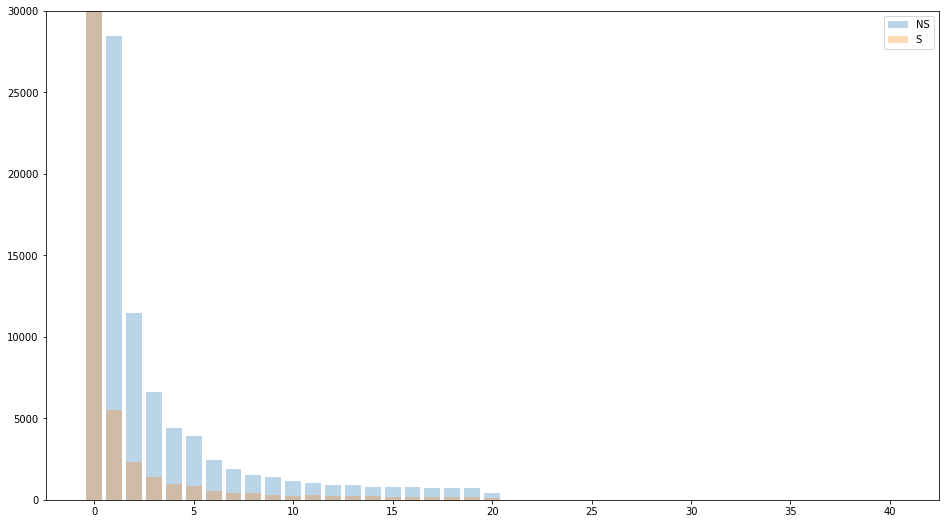

In [31]:
graph.figure(figsize=(16,9))
graph.bar(folded_sfs_df.index, folded_sfs_df['selected'], label='NS', alpha=0.3)
graph.bar(folded_sfs_df.index, folded_sfs_df['four_fold'], label = 'S', alpha=0.3)
graph.legend()
graph.ylim(0, 30000)
graph.show()

In [171]:
for i in trange(1):
    sfs_whole(i, t18_worker_genes)




  0%|          | 0/1 [00:00<?, ?it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
prop_muts_in_s_ranges.c: version 1.02
Output file expected
Opened file /home/arshad/solenopsis-worker-gene-afs/bootstrapping/dfe-estimates-worker/run-0-estimates.txt for write, overwrite mode.
n2 184.060000
es -5.787878
beta 0.185300
mean_ns 1065.316825
lower 0.000000 upper 1.000000 area 0.218025
lower 1.000000 upper 10.000000 area 0.115939
lower 10.000000 upper 100.000000 area 0.176471
lower 100.000000 upper -99.000000 area 0.489564
Total area 1.000000





100%|██████████| 1/1 [00:11<00:00, 11.92s/it]




In [50]:
for i in trange(1):
    sfs_whole(i, queen_genes)


  0%|          | 0/1 [00:00<?, ?it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



100%|██████████| 1/1 [00:13<00:00, 13.20s/it]


In [132]:
for i in trange(1):
    sfs_whole(i, worker_genes)



  0%|          | 0/1 [00:00<?, ?it/s]



KeyboardInterrupt: 

In [130]:
for i in trange(1):
    sfs_whole(i, adult_queen_genes)



  0%|          | 0/1 [00:00<?, ?it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
prop_muts_in_s_ranges.c: version 1.02
Output file expected
Opened file /home/arshad/solenopsis-worker-gene-afs/bootstrapping/dfe-estimates-worker/run-0-estimates.txt for write, overwrite mode.
n2 151.240000
es -343460.217880
beta 0.050000
mean_ns 51944923.352171
lower 0.000000 upper 1.000000 area 0.363776
lower 1.000000 upper 10.000000 area 0.044387
lower 10.000000 upper 100.000000 area 0.049803
lower 100.000000 upper -99.000000 area 0.542034
Total area 1.000000




100%|██████████| 1/1 [00:16<00:00, 16.85s/it]



In [89]:
for i in trange(1):
    sfs_whole(i, adult_worker_genes)


  0%|          | 0/1 [00:00<?, ?it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
prop_muts_in_s_ranges.c: version 1.02
Output file expected
Opened file /home/arshad/solenopsis-worker-gene-afs/bootstrapping/dfe-estimates-worker/run-0-estimates.txt for write, overwrite mode.
n2 151.240000
es -73.264762
beta 0.097800
mean_ns 11080.562605
lower 0.000000 upper 1.000000 area 0.336473
lower 1.000000 upper 10.000000 area 0.084978
lower 10.000000 upper 100.000000 area 0.106406
lower 100.000000 upper -99.000000 area 0.472144
Total area 1.000000



100%|██████████| 1/1 [00:16<00:00, 16.58s/it]


In [159]:
from joblib import Parallel, delayed, parallel_backend

In [166]:
%%time

# with parallel_backend('threading'):
Parallel(n_jobs=40, backend='multiprocessing')(delayed(sfs_whole)(i, np.random.choice(t18_worker_genes, 
                                                                                      len(t18_worker_genes))) for i in trange(5000))




  0%|          | 0/5000 [00:00<?, ?it/s]


  0%|          | 1/5000 [00:02<3:18:55,  2.39s/it]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




  2%|▏         | 80/5000 [00:21<2:23:06,  1.75s/it]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




  2%|▏         | 120/5000 [00:55<2:00:01,  1.48s/it]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




  3%|▎         | 160/5000 [01:30<1:44:06,  1.29s/it]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




  4%|▍         | 200/5000 [02:08<1:35:28,  1.19s/it]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




  5%|▍         | 240/5000 [02:51<1:31:56,  1.16s/it]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




  6%|▌         | 280/5000 [03:23<1:22:33,  1.05s/it]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




  6%|▋         | 320/5000 [03:56<1:16:36,  1.02it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




  7%|▋         | 360/5000 [04:39<1:18:04,  1.01s/it]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




  8%|▊         | 400/5000 [05:14<1:14:23,  1.03it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




  9%|▉         | 440/5000 [05:50<1:11:45,  1.06it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 10%|▉         | 480/5000 [06:27<1:10:48,  1.06it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 10%|█         | 520/5000 [07:02<1:08:57,  1.08it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 11%|█         | 560/5000 [07:40<1:08:35,  1.08it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 12%|█▏        | 600/5000 [08:19<1:09:24,  1.06it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 13%|█▎        | 640/5000 [08:56<1:08:24,  1.06it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 14%|█▎        | 680/5000 [09:32<1:06:39,  1.08it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 14%|█▍        | 720/5000 [10:07<1:05:00,  1.10it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 15%|█▌        | 760/5000 [10:43<1:03:57,  1.10it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 16%|█▌        | 800/5000 [11:17<1:02:08,  1.13it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 17%|█▋        | 840/5000 [11:51<1:00:55,  1.14it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 18%|█▊        | 880/5000 [12:32<1:03:14,  1.09it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 18%|█▊        | 920/5000 [13:11<1:03:40,  1.07it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 19%|█▉        | 960/5000 [13:49<1:03:18,  1.06it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 20%|██        | 1000/5000 [14:19<58:58,  1.13it/s] 

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 21%|██        | 1040/5000 [14:59<1:00:55,  1.08it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 22%|██▏       | 1080/5000 [15:37<1:00:32,  1.08it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 22%|██▏       | 1120/5000 [16:11<58:24,  1.11it/s]  

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 23%|██▎       | 1160/5000 [16:46<57:39,  1.11it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 24%|██▍       | 1200/5000 [17:21<56:31,  1.12it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 25%|██▍       | 1240/5000 [17:59<57:03,  1.10it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 26%|██▌       | 1280/5000 [18:35<56:01,  1.11it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 26%|██▋       | 1320/5000 [19:12<55:58,  1.10it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 27%|██▋       | 1360/5000 [19:49<55:33,  1.09it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 28%|██▊       | 1400/5000 [20:23<53:35,  1.12it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 29%|██▉       | 1440/5000 [20:56<51:48,  1.15it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 30%|██▉       | 1480/5000 [21:31<51:23,  1.14it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 30%|███       | 1520/5000 [22:09<52:11,  1.11it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 31%|███       | 1560/5000 [22:44<50:50,  1.13it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 32%|███▏      | 1600/5000 [23:21<51:00,  1.11it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 33%|███▎      | 1640/5000 [23:55<49:37,  1.13it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 34%|███▎      | 1680/5000 [24:30<48:57,  1.13it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 34%|███▍      | 1720/5000 [25:06<48:38,  1.12it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 35%|███▌      | 1760/5000 [25:43<48:25,  1.12it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 36%|███▌      | 1800/5000 [26:25<50:18,  1.06it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 37%|███▋      | 1840/5000 [26:56<46:49,  1.12it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 38%|███▊      | 1880/5000 [27:28<45:07,  1.15it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 38%|███▊      | 1920/5000 [28:06<45:33,  1.13it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 39%|███▉      | 1960/5000 [28:47<47:03,  1.08it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 40%|████      | 2000/5000 [29:25<46:57,  1.06it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 41%|████      | 2040/5000 [29:55<43:19,  1.14it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 42%|████▏     | 2080/5000 [30:36<44:54,  1.08it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 42%|████▏     | 2120/5000 [31:14<44:58,  1.07it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 43%|████▎     | 2160/5000 [31:53<44:41,  1.06it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 44%|████▍     | 2200/5000 [32:26<42:35,  1.10it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 45%|████▍     | 2240/5000 [33:07<43:28,  1.06it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 46%|████▌     | 2280/5000 [33:41<41:31,  1.09it/s]

nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 46%|████▋     | 2320/5000 [34:19<41:25,  1.08it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 47%|████▋     | 2360/5000 [34:53<39:41,  1.11it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 48%|████▊     | 2400/5000 [35:30<39:18,  1.10it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin

nohup: ignoring input and appending output to 'nohup.out'


 49%|████▉     | 2440/5000 [36:09<39:37,  1.08it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 50%|████▉     | 2480/5000 [36:47<39:24,  1.07it/s]

nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 50%|█████     | 2520/5000 [37:20<37:17,  1.11it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 51%|█████     | 2560/5000 [37:57<36:55,  1.10it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 52%|█████▏    | 2600/5000 [38:35<36:41,  1.09it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 53%|█████▎    | 2640/5000 [39:11<35:59,  1.09it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 54%|█████▎    | 2680/5000 [39:47<35:18,  1.10it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 54%|█████▍    | 2720/5000 [40:21<34:00,  1.12it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 55%|█████▌    | 2760/5000 [40:59<33:56,  1.10it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 56%|█████▌    | 2800/5000 [41:34<33:01,  1.11it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 57%|█████▋    | 2840/5000 [42:13<33:01,  1.09it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 58%|█████▊    | 2880/5000 [42:48<32:04,  1.10it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 58%|█████▊    | 2920/5000 [43:23<31:13,  1.11it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 59%|█████▉    | 2960/5000 [44:00<30:53,  1.10it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 60%|██████    | 3000/5000 [44:39<30:44,  1.08it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 61%|██████    | 3040/5000 [45:16<30:14,  1.08it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 62%|██████▏   | 3080/5000 [45:53<29:36,  1.08it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 62%|██████▏   | 3120/5000 [46:24<27:37,  1.13it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 63%|██████▎   | 3160/5000 [47:01<27:18,  1.12it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 64%|██████▍   | 3200/5000 [47:40<27:37,  1.09it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 65%|██████▍   | 3240/5000 [48:20<27:37,  1.06it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 66%|██████▌   | 3280/5000 [48:58<27:01,  1.06it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 66%|██████▋   | 3320/5000 [49:35<26:15,  1.07it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 67%|██████▋   | 3360/5000 [50:15<26:11,  1.04it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 68%|██████▊   | 3400/5000 [50:48<24:29,  1.09it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 69%|██████▉   | 3440/5000 [51:22<23:22,  1.11it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 70%|██████▉   | 3480/5000 [51:59<22:52,  1.11it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 70%|███████   | 3520/5000 [52:34<22:08,  1.11it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 71%|███████   | 3560/5000 [53:08<21:12,  1.13it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 72%|███████▏  | 3600/5000 [53:46<21:05,  1.11it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 73%|███████▎  | 3640/5000 [54:19<19:53,  1.14it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 74%|███████▎  | 3680/5000 [54:54<19:18,  1.14it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 74%|███████▍  | 3720/5000 [55:28<18:34,  1.15it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 75%|███████▌  | 3760/5000 [56:01<17:42,  1.17it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 76%|███████▌  | 3800/5000 [56:35<17:06,  1.17it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 77%|███████▋  | 3840/5000 [57:19<17:56,  1.08it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 78%|███████▊  | 3880/5000 [57:55<17:10,  1.09it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 78%|███████▊  | 3920/5000 [58:29<16:06,  1.12it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 79%|███████▉  | 3960/5000 [59:04<15:28,  1.12it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 80%|████████  | 4000/5000 [59:40<14:54,  1.12it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 81%|████████  | 4040/5000 [1:00:18<14:33,  1.10it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 82%|████████▏ | 4080/5000 [1:00:56<14:11,  1.08it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 82%|████████▏ | 4120/5000 [1:01:31<13:21,  1.10it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 83%|████████▎ | 4160/5000 [1:02:07<12:39,  1.11it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 84%|████████▍ | 4200/5000 [1:02:45<12:12,  1.09it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 85%|████████▍ | 4240/5000 [1:03:18<11:16,  1.12it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 86%|████████▌ | 4280/5000 [1:03:56<10:57,  1.09it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 86%|████████▋ | 4320/5000 [1:04:30<10:07,  1.12it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 87%|████████▋ | 4360/5000 [1:05:10<09:50,  1.08it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 88%|████████▊ | 4400/5000 [1:05:47<09:14,  1.08it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 89%|████████▉ | 4440/5000 [1:06:24<08:38,  1.08it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 90%|████████▉ | 4480/5000 [1:06:58<07:50,  1.11it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 90%|█████████ | 4520/5000 [1:07:33<07:09,  1.12it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 91%|█████████ | 4560/5000 [1:08:08<06:28,  1.13it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 92%|█████████▏| 4600/5000 [1:08:47<06:06,  1.09it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 93%|█████████▎| 4640/5000 [1:09:25<05:32,  1.08it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 94%|█████████▎| 4680/5000 [1:10:04<05:00,  1.06it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 94%|█████████▍| 4720/5000 [1:10:40<04:18,  1.08it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 95%|█████████▌| 4760/5000 [1:11:15<03:39,  1.09it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 96%|█████████▌| 4800/5000 [1:11:53<03:04,  1.08it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 97%|█████████▋| 4840/5000 [1:12:30<02:27,  1.08it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 98%|█████████▊| 4880/5000 [1:13:03<01:46,  1.12it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 98%|█████████▊| 4920/5000 [1:13:39<01:11,  1.11it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




 99%|█████████▉| 4960/5000 [1:14:22<00:37,  1.05it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin




100%|██████████| 5000/5000 [1:14:54<00:00,  1.10it/s]




nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [167]:
negative_selection = [] # Will be at the complete top of the script

path_folder = '/home/arshad/solenopsis-worker-gene-afs/bootstrapping/dfe-estimates-worker/'

for file in tqdm(os.listdir(path_folder), total=len(path_folder)):
    if os.stat(f'{path_folder}/{file}').st_size == 0:
        continue
    df = pd.read_csv(f'{path_folder}/{file}', sep=' ', header=None)
    df.columns = ['rand1', 'rand2', 'one', 'rand3', 'rand4', 'ten', 'rand5', 'rand6', 'hundred', 'rand7', 
                  'rand8', 'infinity', 'check']
    df.drop(columns =[column for column in df.columns if 'rand' in column], inplace=True)
    
    negative_selection.append(df)

missense_estimates = pd.concat(negative_selection)
missense_estimates
missense_estimates.to_csv('/home/arshad/solenopsis-2018-study-worker-missense-all-parallel-proper-5kiterations.csv', index=False) #<-----




  0%|          | 0/75 [00:00<?, ?it/s]


 21%|██▏       | 16/75 [00:00<00:00, 152.63it/s]


 48%|████▊     | 36/75 [00:00<00:00, 163.97it/s]


 76%|███████▌  | 57/75 [00:00<00:00, 174.12it/s]


78it [00:00, 182.16it/s]                        


98it [00:00, 186.46it/s]


118it [00:00, 190.29it/s]


139it [00:00, 193.86it/s]


160it [00:00, 196.31it/s]


181it [00:00, 197.95it/s]


202it [00:01, 198.67it/s]


223it [00:01, 199.99it/s]


244it [00:01, 200.88it/s]


264it [00:01, 200.53it/s]


284it [00:01, 196.42it/s]


304it [00:01, 183.98it/s]


323it [00:01, 166.52it/s]


341it [00:01, 167.05it/s]


360it [00:01, 173.28it/s]


378it [00:02, 156.21it/s]


396it [00:02, 162.38it/s]


417it [00:02, 172.37it/s]


438it [00:02, 179.99it/s]


458it [00:02, 185.24it/s]


478it [00:02, 188.98it/s]


498it [00:02, 191.82it/s]


518it [00:02, 194.11it/s]


539it [00:02, 196.07it/s]


559it [00:03, 167.82it/s]


577it [00:03, 160.63it/s]


598it [00:03, 171.48it/s]


619it [00:03, 181.03it/s]

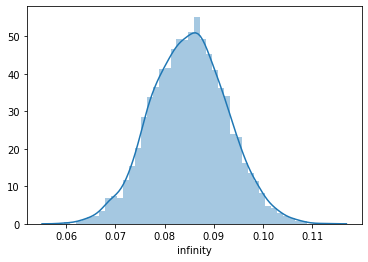

In [81]:
sns.distplot(missense_estimates['infinity'])

In [71]:
intergenic['cal_af'].value_counts()

0.0     48087900
1.0       141727
2.0        61406
3.0        37022
4.0        25117
5.0        21115
6.0        14250
7.0        11943
8.0         9785
9.0         8548
10.0        7386
11.0        6464
12.0        6198
13.0        5820
14.0        5381
15.0        5221
19.0        5037
16.0        4852
18.0        4848
17.0        4649
20.0        2423
Name: cal_af, dtype: int64

# Gene expression

In [38]:
adult_queen_SI2_genes = ['SI2.2.0_03575', 'SI2.2.0_06893', 'SI2.2.0_01626', 'SI2.2.0_10550']
adult_worker_SI2_genes = ['SI2.2.0_09202', 'SI2.2.0_14298', 'SI2.2.0_08330', 'SI2.2.0_05893', 'SI2.2.0_01139', 'SI2.2.0_10859',
'SI2.2.0_11205', 'SI2.2.0_15321', 'SI2.2.0_00525', 'SI2.2.0_03937', 'SI2.2.0_13201', 'SI2.2.0_06361',
'SI2.2.0_05639', 'SI2.2.0_05773', 'SI2.2.0_09817', 'SI2.2.0_08834', 'SI2.2.0_07107', 'SI2.2.0_14899', 'SI2.2.0_03207', 
                          'SI2.2.0_00270',
'SI2.2.0_11559', 'SI2.2.0_13745', 'SI2.2.0_02641', 'SI2.2.0_05042', 'SI2.2.0_15170', 'SI2.2.0_06136', 'SI2.2.0_10075', 'SI2.2.0_09097',
'SI2.2.0_08802', 'SI2.2.0_02306', 'SI2.2.0_01816', 'SI2.2.0_11293', 'SI2.2.0_16038', 'SI2.2.0_03826', 'SI2.2.0_01907', 'SI2.2.0_05469',
'SI2.2.0_02037', 'SI2.2.0_10465', 'SI2.2.0_06265', 'SI2.2.0_01390', 'SI2.2.0_15207', 'SI2.2.0_00589', 'SI2.2.0_09889', 'SI2.2.0_11380',
'SI2.2.0_00788', 'SI2.2.0_09769', 'SI2.2.0_02578', 'SI2.2.0_14342', 'SI2.2.0_10924', 'SI2.2.0_15747', 'SI2.2.0_10727', 'SI2.2.0_15663',
'SI2.2.0_08375', 'SI2.2.0_03790', 'SI2.2.0_02896', 'SI2.2.0_11324', 'SI2.2.0_06846', 'SI2.2.0_12334', 'SI2.2.0_06951', 'SI2.2.0_14693', 'SI2.2.0_00775', 'SI2.2.0_00452', 'SI2.2.0_05077',
'SI2.2.0_14476', 'SI2.2.0_01464', 'SI2.2.0_05695', 'SI2.2.0_05747', 'SI2.2.0_11534', 'SI2.2.0_02818', 'SI2.2.0_12181', 'SI2.2.0_12222',
'SI2.2.0_08536', 'SI2.2.0_01366', 'SI2.2.0_05768']

In [40]:
# List of queen and worker genes
master_gene_lists = pd.read_csv('/home/arshad/Gene_expression/Solenopsis/eyal_sinv_loc_xm_genes.csv')
queen_genes_df = pd.read_csv('/home/arshad/Gene_expression/Solenopsis/queen_genes.csv', header=None)
worker_genes_df = pd.read_csv('/home/arshad/Gene_expression/Solenopsis/worker_genes.csv', header=None)

temp_worker_genes_list = np.unique(adult_worker_SI2_genes)
temp_queen_genes_list = np.unique(adult_queen_SI2_genes)
print(len(temp_worker_genes_list), len(temp_queen_genes_list))
display(master_gene_lists.head())

worker_genes_list = [gene for gene in temp_worker_genes_list if gene not in temp_queen_genes_list]
queen_genes_list = [gene for gene in temp_queen_genes_list if gene not in temp_worker_genes_list]

print(len(worker_genes_list), len(queen_genes_list))

adult_queen_genes = list(master_gene_lists[master_gene_lists['eyal_gene_name'].isin(queen_genes_list)]['xm_gene_name'].unique())
adult_worker_genes = list(master_gene_lists[master_gene_lists['eyal_gene_name'].isin(worker_genes_list)]['xm_gene_name'].unique())

print(len(adult_worker_genes), len(adult_queen_genes))

74 4


,Unnamed: 0,eyal_gene_name,sinv_gene_name,loc_identifier_number,loc_name,gene_description,xm_gene_name,Unnamed: 1,mrna_length,scaffold,start,end
0,0,SI2.2.0_00015,SINV11325,105196335,LOC105196335,uncharacterized LOC105196335,XM_011162235.2,NaN,6374,NW_020521546.1,834909,841282
1,1,SI2.2.0_00015,SINV11325,105196335,LOC105196335,uncharacterized LOC105196335,XM_011162236.2,NaN,6376,NW_020521546.1,834907,841282
2,2,SI2.2.0_00016,SINV16609,105199034,LOC105199034,RING finger and transmembrane domain-containing protein 2,XM_011165937.2,NaN,4991,NW_020521549.1,1768901,1773891
3,3,SI2.2.0_00016,SINV16609,105199034,LOC105199034,RING finger and transmembrane domain-containing protein 2,XM_011165938.2,NaN,4281,NW_020521549.1,1769235,1773515
4,4,SI2.2.0_00016,SINV16609,105199034,LOC105199034,RING finger and transmembrane domain-containing protein 2,XM_011165939.2,NaN,2071,NW_020521549.1,1771445,1773515


74 4
154 7


In [112]:
# 2018 Genes

df = pd.read_csv('/home/arshad/Gene_expression/Solenopsis/sinv_LOC_caste_biased_genes.csv')
df = df[df['Sinv_padj'] < 0.05]
df['sinv_gene_names'] = df['Sinv'].str.split('|').str.get(1)
display(df.head())
queens_2018 = list(df[df['Sinv_log2FoldChange'] > 0]['sinv_gene_names'].unique())
workers_2018 = list(df[df['Sinv_log2FoldChange'] < 0]['sinv_gene_names'].unique())

print(len(queens_2018), len(workers_2018))

queen_genes = list(master_gene_lists[master_gene_lists['loc_name'].isin(queens_2018)]['xm_gene_name'].unique())
worker_genes = list(master_gene_lists[master_gene_lists['loc_name'].isin(workers_2018)]['xm_gene_name'].unique())

print(len(worker_genes), len(queen_genes))

,Unnamed: 0,Sinv,Sinv_baseMean,Sinv_log2FoldChange,Sinv_padj,sinv_gene_names
3596,3916,Sinv|LOC105202201,821.296633,-0.109903,0.049982,LOC105202201
3597,3219,Sinv|LOC105195405,210.963597,0.229748,0.049604,LOC105195405
3598,3488,Sinv|LOC105195931,445.333672,-0.233293,0.049586,LOC105195931
3599,7155,Sinv|LOC105205681,453.053085,0.193979,0.049568,LOC105205681
3600,2644,Sinv|LOC105194528,505.147375,-0.481403,0.049530,LOC105194528


880 1045
245 403


In [111]:
master_gene_lists.head()

,Unnamed: 0,eyal_gene_name,sinv_gene_name,loc_identifier_number,loc_name,gene_description,xm_gene_name,Unnamed: 1,mrna_length,scaffold,start,end
0,0,SI2.2.0_00015,SINV11325,105196335,LOC105196335,uncharacterized LOC105196335,XM_011162235.2,NaN,6374,NW_020521546.1,834909,841282
1,1,SI2.2.0_00015,SINV11325,105196335,LOC105196335,uncharacterized LOC105196335,XM_011162236.2,NaN,6376,NW_020521546.1,834907,841282
2,2,SI2.2.0_00016,SINV16609,105199034,LOC105199034,RING finger and transmembrane domain-containing protein 2,XM_011165937.2,NaN,4991,NW_020521549.1,1768901,1773891
3,3,SI2.2.0_00016,SINV16609,105199034,LOC105199034,RING finger and transmembrane domain-containing protein 2,XM_011165938.2,NaN,4281,NW_020521549.1,1769235,1773515
4,4,SI2.2.0_00016,SINV16609,105199034,LOC105199034,RING finger and transmembrane domain-containing protein 2,XM_011165939.2,NaN,2071,NW_020521549.1,1771445,1773515
